### Final results: using alpha = .01, lambda = .0001

    Logistic regression: test accuracy ~.75, test cost ~.68
    
    NN - one hidden layer:
        early stopping: test accuracy ~.79, test cost ~.55
        
    NN - two hidden layers:
        early stopping: test accuracy ~.79 , test cost ~.54
        regularization and early stopping: test accuracy ~.8, test cost ~.53       
        
    

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")

Let's have a look....

In [3]:
train.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15470.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30939.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46408.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61878.000000,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


~62K training examples. 

The features are a sparse matrix, with ~75% having zero values.

## Getting the data into shape.

Seperate the features and the labels

In [4]:
X = train.loc[:, "feat_1":"feat_93"]
Y = train.loc[:, "target"]
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))

X shape: (61878, 93)
Y shape: (61878,)


Convert labels to one-hot encoding

In [5]:
one_hot_encoding = pd.get_dummies(Y)
#Y = one_hot_encoding
print("New Y shape: " + str(one_hot_encoding.shape))

New Y shape: (61878, 9)


Now let's randomly shuffle them, so that we'll be able to do batch gradient descent

In [6]:
shuffle_index = np.random.permutation(train.index)
shuffled_X = X.reindex(shuffle_index)
shuffled_Y = Y.reindex(shuffle_index)
shuffled_one_hot = one_hot_encoding.reindex(shuffle_index)

Now we're ready to split them into train/test sets.

I've been led to believe that 10,000 should be more than enough for testing.

In [7]:
test_size = 10000
X_test = shuffled_X[0:test_size]
X_train = shuffled_X[test_size:]
Y_test = shuffled_one_hot[0:test_size]
Y_train = shuffled_one_hot[test_size:]
print("train features shape: " + str(X_train.shape))
print("train labels shape: " + str(Y_train.shape))
print("")
print("test features shape: " + str(X_test.shape))
print("test labels shape: " + str(Y_test.shape))

train features shape: (51878, 93)
train labels shape: (51878, 9)

test features shape: (10000, 93)
test labels shape: (10000, 9)


Let's normalize the inputs by dividing by max of each feature, to get them between 0 and 1.  
(We take those from the whole X, so it's consistent for the test set as well)

In [8]:
max_X = X.max()
#var_X = X.var()
X_train_normalized = X_train.div(max_X, axis = 1)
#X_train_normalized = X_train.div(var_X, axis = 1)

X_test_normalized = X_test.div(max_X, axis = 1)
#X_test_normalized = X_test.div(var_X, axis = 1)

## Ready for tensorflow (choose one of the models)

### Model #1 - Logistic Regression

In [9]:
X_batch = tf.placeholder(tf.float32, [93, None]) # 93 by mini-batch size
Y_batch = tf.placeholder(tf.float32, [9, None])

W = tf.Variable(tf.random_uniform([9, 93]) * tf.sqrt(2/138))
b = tf.Variable(tf.random_uniform([9, 1]))

Z = tf.matmul(W, X_batch) + b

# we need to transpose them, to work with the cross_entropy function, so now they become of shape m * 9 instead
Y_labels = tf.transpose(Y_batch)
Y_logits = tf.transpose(Z)

### Model #2 - NN, one hidden layer

In [266]:
X_batch = tf.placeholder(tf.float32, [93, None]) # 93 by mini-batch size
Y_batch = tf.placeholder(tf.float32, [9, None])

W1 = tf.Variable(tf.random_uniform([45, 93]) * tf.sqrt(2/138))
b1 = tf.Variable(tf.random_uniform([45, 1]))

Z1 = tf.matmul(W1, X_batch) + b1
A1 = tf.nn.relu(Z1) # 45 by mini-batch size

W2 = tf.Variable(tf.random_uniform([9, 45]) * tf.sqrt(2/65))
b2 = tf.Variable(tf.random_uniform([9, 1]))

Z2 = tf.matmul(W2, A1) + b2

# we need to transpose them, to work with the cross_entropy function, so now they become of shape m * 9 instead
Y_labels = tf.transpose(Y_batch)
Y_logits = tf.transpose(Z2)

### Model #3 - NN, 2 hidden layers

In [13]:
X_batch = tf.placeholder(tf.float32, [93, None]) # 93 by mini-batch size
Y_batch = tf.placeholder(tf.float32, [9, None])

W1 = tf.Variable(tf.random_uniform([45, 93]) * tf.sqrt(2/93))
b1 = tf.Variable(tf.random_uniform([45, 1]))

Z1 = tf.matmul(W1, X_batch) + b1
A1 = tf.nn.relu(Z1) # 45 by mini-batch size

W2 = tf.Variable(tf.random_uniform([20, 45]) * tf.sqrt(2/45))
b2 = tf.Variable(tf.random_uniform([20, 1]))

Z2 = tf.matmul(W2, A1) + b2
A2 = tf.nn.relu(Z2) # 20 by mini-batch size

W3 = tf.Variable(tf.random_uniform([9, 20]) * tf.sqrt(2/45))
b3 = tf.Variable(tf.random_uniform([9, 1]))

Z3 = tf.matmul(W3, A2) + b3 # 9 by mini-batch size

# we need to transpose them, to work with the cross_entropy function, so now they become of shape m * 9 instead
Y_labels = tf.transpose(Y_batch)
Y_logits = tf.transpose(Z3)

### For all models, setting up training and evaluation (choose appropriate regularization)

In [10]:
# this is for training
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_labels, logits=Y_logits))

# regularization...
#lambd = .0001

# for logistic regression
#regularization = tf.nn.l2_loss(W)

# for one-layer nn
#regularization = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)

# for 2-layer nn
#regularization = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W2)

#cross_entropy = cross_entropy + (regularization * lambd)

# These are the predictions, and the actual labels, in a standardized form
actual_predictions = tf.argmax(Y_logits, 1)
actual_labels = tf.argmax(Y_labels, 1)

# and this is for evaluation
correct_prediction = tf.equal(actual_predictions, actual_labels)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

# need to manually evaluate loss for the test set, where we're not training
manual_softmax = tf.nn.softmax(logits=Y_logits)
manual_mask = tf.equal(Y_labels, 1)
manual_cost = tf.boolean_mask(manual_softmax, manual_mask)

## Initialize variables for the session

In [11]:
alpha = 3

#train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(alpha).minimize(cross_entropy)

session = tf.InteractiveSession()

init = tf.global_variables_initializer()
init.run()

## Ready for training!

In [12]:
epoch_counts = [0]
epoch_costs = [np.mean(np.log(manual_cost.eval({X_batch: np.transpose(X_test_normalized), 
                  Y_batch: np.transpose(Y_test)})) * -1)]
epoch_test_costs = [np.mean(np.log(manual_cost.eval({X_batch: np.transpose(X_test_normalized), 
                  Y_batch: np.transpose(Y_test)})) * -1)]
epoch_train_accuracies = []
epoch_test_accuracies = []
current_epoch = 0

epoch_train_accuracies.append(accuracy.eval({X_batch: np.transpose(X_train_normalized), 
                                             Y_batch: np.transpose(Y_train)}))
epoch_test_accuracies.append(accuracy.eval({X_batch: np.transpose(X_test_normalized), 
                                            Y_batch: np.transpose(Y_test)}))


In [13]:
batch_size = 1000
batches_in_epoch = int(X_train.shape[0] / batch_size)
remainder = X_train.shape[0] % batch_size
train_epochs = 450 # should be enough, see where the peek is, then rerun that amount


batch_start = 0

for i in range(train_epochs):
    current_epoch += 1 # one-index based

    step_cost = []
    # train on the batches
    for j in range(batches_in_epoch):
        batch_start = j * batch_size
        batch_end = batch_start + batch_size
        _, iter_cost = session.run([train_step, cross_entropy], 
                                   {X_batch: np.transpose(X_train_normalized.iloc[batch_start:batch_end]), 
                                    Y_batch: np.transpose(Y_train.iloc[batch_start:batch_end])})
        step_cost.append(iter_cost)

            
    # train on the remainder
    batch_start = batches_in_epoch * batch_size
    _, iter_cost = session.run([train_step, cross_entropy], 
                               {X_batch: np.transpose(X_train_normalized.iloc[batch_start:]), 
                                Y_batch: np.transpose(Y_train.iloc[batch_start:])})
    step_cost.append(iter_cost)

    # save the cost and accuracy for plotting every 10 epochs
    if current_epoch % 10 == 0:
        epoch_counts.append(current_epoch)
        epoch_train_accuracies.append(accuracy.eval({X_batch: np.transpose(X_train_normalized), 
                                                     Y_batch: np.transpose(Y_train)}))
        epoch_test_accuracies.append(accuracy.eval({X_batch: np.transpose(X_test_normalized), 
                                                     Y_batch: np.transpose(Y_test)}))
        epoch_costs.append(sum(step_cost) / float(len(step_cost)))
        epoch_test_costs.append(np.mean(np.log(manual_cost.eval({X_batch: np.transpose(X_test_normalized), 
                  Y_batch: np.transpose(Y_test)})) * -1))
        print("epoch #" + str(current_epoch), 
              "| train accuracy: " + str(epoch_train_accuracies[-1]), ",cost: " + str(epoch_costs[-1]),
              "| test accuracy: " + str(epoch_test_accuracies[-1]), ",cost: " + str(epoch_test_costs[-1]))

epoch #10 | train accuracy: 0.68032694 ,cost: 1.0666190019020667 | test accuracy: 0.6793 ,cost: 1.0548421
epoch #20 | train accuracy: 0.70388216 ,cost: 0.932797820522235 | test accuracy: 0.6992 ,cost: 0.9306674
epoch #30 | train accuracy: 0.713231 ,cost: 0.8720884380432276 | test accuracy: 0.7089 ,cost: 0.87370616
epoch #40 | train accuracy: 0.7188018 ,cost: 0.8359915614128113 | test accuracy: 0.7146 ,cost: 0.8398199
epoch #50 | train accuracy: 0.7227341 ,cost: 0.8114697864422431 | test accuracy: 0.7189 ,cost: 0.81681687
epoch #60 | train accuracy: 0.7265315 ,cost: 0.7934275854092377 | test accuracy: 0.7218 ,cost: 0.79989815
epoch #70 | train accuracy: 0.72872895 ,cost: 0.7794344058403602 | test accuracy: 0.7244 ,cost: 0.7867746
epoch #80 | train accuracy: 0.73042524 ,cost: 0.7681700518498054 | test accuracy: 0.7257 ,cost: 0.77620476
epoch #90 | train accuracy: 0.732295 ,cost: 0.7588482533509915 | test accuracy: 0.7277 ,cost: 0.7674508
epoch #100 | train accuracy: 0.7337985 ,cost: 0.75

final train accuracy after 450 epochs is: 0.7534600496292114
final test accuracy after 450 epochs is: 0.7480000257492065
final train cost after 450 epochs is: 0.6742087075343499
final test cost after 450 epochs is: 0.6872208714485168


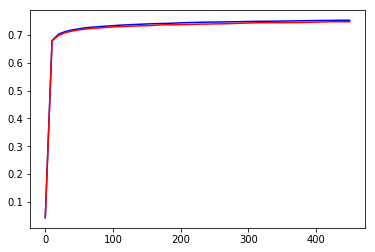

In [14]:
import matplotlib.pyplot as plt
epoch_start = 0
epoch_end = len(epoch_test_accuracies)
plt.plot(epoch_counts[epoch_start:], epoch_train_accuracies[epoch_start:], "b",
         epoch_counts[epoch_start:], epoch_test_accuracies[epoch_start:], "r")
print("final train accuracy after {} epochs is: {}".format(epoch_counts[-1], epoch_train_accuracies[-1]))
print("final test accuracy after {} epochs is: {}".format(epoch_counts[-1], epoch_test_accuracies[-1]))
print("final train cost after {} epochs is: {}".format(epoch_counts[-1], epoch_costs[-1]))
print("final test cost after {} epochs is: {}".format(epoch_counts[-1], epoch_test_costs[-1]))

### Let's try some feature engineering

These are black box features, hard to engineer.

Still, some ideas...
* get most important features, and create new features of the difference between them (would think that it doesn't add much for neural nets, that could learn linear features, but saw from someone that it's helpful.
* binary features of whether feature is 0 or not.
* binary features of whether combination of correlated features are present
* binning values.
* Saw that XGboost can be used to find new features.

### let's use scikit to do logistic regression, and get the most important features. Maybe...

In [329]:
import sklearn.linear_model

In [330]:
log_model = sklearn.linear_model.LogisticRegression()

In [331]:
Y_train_singlecol = Y_train.idxmax(axis = 1)
Y_train_singlecol.shape

(51878,)

In [332]:
log_model.fit(X_train_normalized, Y_train_singlecol)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [335]:
score = log_model.score(X_train_normalized, Y_train_singlecol)
print("score is: {}".format(score))
coef = log_model.coef_[0]

score is: 0.729731292648136


In [336]:
coef_copy = coef
len(coef_copy)

93

In [337]:
sort_index = (abs(coef_copy) * -1).argsort()
best_features = sort_index[0:10]
best_features

array([33, 10, 24, 13, 39, 16,  8, 14, 68, 66], dtype=int64)

so the most relevant features are the ones above.  
let's make tuples of pairs of each of those, which will be a total of (10 * 9) / 2

In [338]:
feature_pairs = []
for i in range(len(best_features)):
    for j in range(i+1, len(best_features)):
        feature_pairs.append((best_features[i], best_features[j]))
len(feature_pairs)

45

For each of those pairs, let's make a new feature which is the difference between them.  
We'll do it on the original pandas X dataframes, X_train and X_test

In [339]:
engineered_X_train = X_train.copy()
engineered_X_test = X_test.copy()

feature_names = list(X_train)
for feature_1, feature_2 in feature_pairs:
    new_feature_name = feature_names[feature_1] + " - " + feature_names[feature_2] 
    engineered_X_train[new_feature_name] = engineered_X_train.iloc[:,feature_1] - engineered_X_train.iloc[:,feature_2]
    
for feature_1, feature_2 in feature_pairs:
    new_feature_name = feature_names[feature_1] + " - " + feature_names[feature_2] 
    engineered_X_test[new_feature_name] = engineered_X_test.iloc[:,feature_1] - engineered_X_test.iloc[:,feature_2]


It's a sparse matrix, so questionable how many of those features will be meaningful

merge the groups for a total of X, for normalizing

In [343]:
engineered_X = engineered_X_test.append(engineered_X_train)
max_engineered_X = engineered_X.max()
engineered_X_train_normalized = engineered_X_train.div(max_engineered_X, axis = 1)
engineered_X_test_normalized = engineered_X_test.div(max_engineered_X, axis = 1)

Now let's plug these values in to the non-engineered variables, so we can run the previous code on them.
The only thing we need to change in the previous code when we run it is that instead of 93, we put in 93+45 = 138

In [344]:
X_train_normalized = engineered_X_train_normalized
X_test_normalized = engineered_X_test_normalized

Ok, go back up there and run things again (change the weight placeholder shapes from 93 to 138 etc.)

Result: No improvement - actually descreased performance.

## Manual Analysis

### Ok, now let's try doing manual logistic regression, and analyze the results to isolate where to focus in feature engineering

Ran manual logistic regression, using code above (gradientDescentOptimizer, no regularization, alpha=3, 500 epochs), until we got to ~.75 accuracy on the test set.

Let's build datasets for analysis.  
Let's make a dataset with three columns - prediction, actual labels, and whether prediction was correct

In [15]:
prediction_metrics = pd.DataFrame(data = actual_predictions.eval({X_batch: np.transpose(X_test_normalized)}), 
                                  columns = ["predictions"])
prediction_metrics["labels"] = pd.Series(actual_labels.eval({Y_batch: np.transpose(Y_test)}))
prediction_metrics["correct_prediction"] = prediction_metrics["predictions"] == prediction_metrics["labels"]
#prediction_metrics[~prediction_metrics["correct_prediction"]]

Now, let's join them to the X_test_normalized dataset  

For that, we need to reset the index for X_test_normalized, and then join them on the index

In [16]:
X_test_normalized = X_test_normalized.reset_index()

In [17]:
X_test_analysis = pd.concat([X_test_normalized, prediction_metrics], axis=1, join_axes=[X_test_normalized.index])

Remove the index row - not needed

In [18]:
X_test_analysis = X_test_analysis.drop(['index'], axis = 1)

let's make a simple bar plot of the different classes in:  
1. the entire test group
2. the group where it was predicted incorrectly

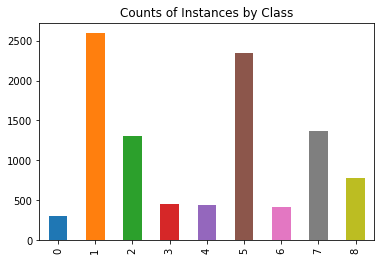

In [19]:
numbers_order = [i for i in range(9)]
X_test_analysis["labels"].value_counts().loc[numbers_order].plot(kind="bar", title = "Counts of Instances by Class")

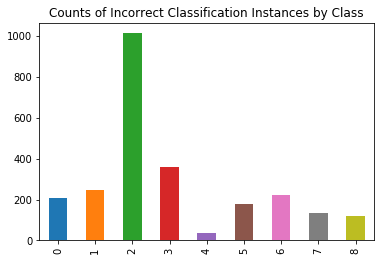

In [20]:
X_test_analysis[~X_test_analysis["correct_prediction"]]["labels"].value_counts().loc[numbers_order].plot(kind="bar",
                                                                title = "Counts of Incorrect Classification Instances by Class")

Seems like the classes are really skewed!  
Makes it hard to interpret the incorrect classification counts.  

Let's standardize them, and look at the percentage of instances that were incorrectly classified.

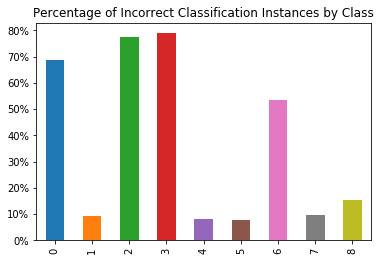

In [21]:
total_counts = X_test_analysis["labels"].value_counts().loc[numbers_order]
incorrect_counts = X_test_analysis[~X_test_analysis["correct_prediction"]]["labels"].value_counts().loc[numbers_order]
incorrect_percentages = incorrect_counts / total_counts
incorrect_plot = (incorrect_percentages * 100).plot(kind="bar", title = "Percentage of Incorrect Classification Instances by Class")
incorrect_plot.set_yticklabels([str(i) + "%" for i in range(0,100,10)])
incorrect_plot

Clearly, classes 1, 3 and 4 are the most misclassified (~80%), with class 7 somewhat less (~50%).  

Of those, class 3 misclassification has the biggest effect on the bottom line, because it is a common class, so it makes sense to begin our focus on feature engineering there.

Classes 1, 4 and 7 are all infrequent classes, which suggests that perhaps we've "underlearnt" for those classes.  
Perhaps the algorithm gave more preference to getting correct predictions for other, more common classes.

Let's see which class labels the algorithm provides for the misclassified instances.

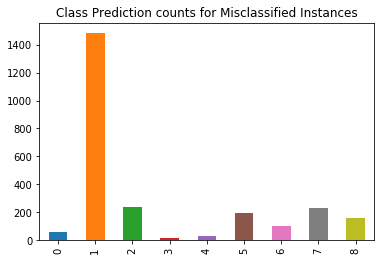

In [22]:
X_test_analysis[~X_test_analysis["correct_prediction"]]["predictions"].value_counts().loc[numbers_order].plot(kind="bar",
                                                            title = "Class Prediction counts for Misclassified Instances")

The vast majority are classified as class_2, which is the most frequently occuring class.

#### In summary:
1. The model is leaning excessively towards class_2, because there are so many instances of it - practically all the mislabeled instances.
2. Conversely, it's performing poorly for several uncommonly occurring classes, namely: 1, 4 and 7.
3. It's performing poorly for class_3, despite it being a commonly occuring class, and this has a bigger effect on the general accuracy of the model.
4. It would seem that class_3 is hard to learn, or at least hard to differentiate from class_2.

####  A few ideas:
1. Let's try training the model without the instances of class_2, and see if accuracy improves for class_3.
2. Let's analyze the weights for class_2 and class_3 prediction (including the weights in class_3 prediction when training without class_2 instances), to see where there's an overlap, and see if feature-engineering on those features can improve accuracy for class_3.